In [1]:
from ase.build import bulk
from ase.visualize import view
from collections import Counter
from ase import Atom
from ase.io import read, write
import numpy as np
import matplotlib.pyplot as plt
from deepmd.infer import DeepPot
from deepmd.infer import calc_model_devi
import os
# from mp_api.client import MPRester
# api_key='VJu07llihiS1dRqq8MPm1OT4p86jWOlc'
from catkit.build import molecule
from catkit.gen.adsorption import Builder
import dpdata
import json
from sklearn.metrics import mean_squared_error
import itertools
import random
import networkx as nx
from ase.utils import formula_hill
from ase.db import connect
from ase.optimize import BFGS
from deepmd.calculator import DP
from itertools import combinations_with_replacement
from scipy.spatial.distance import cdist
from ase import Atoms
from scipy.spatial.distance import cdist
from ase.geometry import get_distances

/ihome/kjohnson/ska31/.conda/envs/deepmdGPU/lib/python3.9/site-packages/ase/constraints.py:5: UserWarning: A NumPy version >=1.22.4 and <1.29.0 is required for this version of SciPy (detected version 1.22.0)
  from scipy.linalg import expm, logm
2025-03-26 08:15:01.283691: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Instructions for updating:
non-resource variables are not supported in the long term


ModuleNotFoundError: No module named 'catkit'

In [12]:
test = '/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/gen-1/neb/neb.explore/00/neb.000/*.out'
int(os.popen(f'grep FIRE {test}').read().split('\n')[-2].split()[1])

69

In [2]:
generation=3 # change generation
#-----------------------------------------------
working_path=f'/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/gen-{generation}/relabel.neb/'
neb_path = f'/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/gen-{generation}/neb/neb.explore/'
# path to the ensemble of DPs - these DPs were used to perform exploration
dp_main_path = f'/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/gen-{generation}/train/'

# path to submit calculations for relabeling
#relabel_dir = '/bgfs/kjohnson/ska31/6AA/reactive_active_learning/ANH/gen-3/relabel/level.01/'
relabel_dir=working_path

# location of all sample VASP files for relabling - you do not need to change these. 
input_path = sample_vasp = '/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/sample-vasp/'

dp_paths= []
for i in range(4):
    dp_paths += [DeepPot(f'{dp_main_path}/dp{i}/graph.pb')]

structpath = f'/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/gen-{generation}/neb/init.struct/'
prods = os.listdir(f'{structpath}/add_adsorbates_mol_only_reorder/')

total_reactions = len(prods)

coord_list = []
boxes_list = []
atypes_list = []
sampled = []

reactants=[x for x in os.listdir(structpath) if 'ReactantOnSlab' in x] # total reactants

for k, r in enumerate(reactants): # iterate over all reactants (4 in this case)
    neb_path_k = f'{neb_path}/{str(k).zfill(2)}/'
    coord_rxn = []
    box_rxn = []
    sampled_rxn = []
    get_atype = 1
    files = []
    files.append(neb_path_k)
    for i in range(0,total_reactions):
        neb_traj = f'{neb_path_k}/final_neb/neb_{str(i).zfill(3)}.traj'
        print(neb_traj)
        converged = int(os.popen(f'grep FIRE {neb_path_k}/neb.{str(i).zfill(3)}/*.out').read().split('\n')[-2].split()[1]) < 200
#         converged = 1 # write a condition to see if NEB has converged. Change code as needed.
        if converged:
            box = []
            coord = []
            pos = read(neb_traj,index=':') 
            sampled_rxn += [neb_traj]
            for l in range(len(pos)):
                im = pos[l]
                box += [np.array(im.cell).ravel()]
                coord += [im.get_positions().ravel()]                
                if get_atype:
                    a=im.get_chemical_symbols()
                    indexes = np.unique(a, return_index=True)[1]
                    type_map = [a[index] for index in sorted(indexes)]
                    type_file = [type_map.index(x) for x in a]
                    atypes_list += [type_file]
                    get_atype = 0
            if len(coord):
                coord_rxn += [coord]
                box_rxn += [box]
#                 f'{neb_path_k}/final_neb/neb_{str(i).zfill(3)}.traj'
    if len(coord_rxn):
        sampled += [sampled_rxn]
        coord_list += [coord_rxn]
        boxes_list += [box_rxn]


2024-09-13 12:16:48.237775: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-13 12:16:48.240248: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/rh/httpd24/root/usr/lib64:/opt/rh/rh-nodejs10/root/usr/lib64:/opt/rh/httpd24/root/usr/lib64
2024-09-13 12:16:48.240288: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2024-09-13 12:16:48.240319: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyterhub.crc.pitt.edu): /proc/driver/n

/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/gen-3/neb/neb.explore//00//final_neb/neb_000.traj
/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/gen-3/neb/neb.explore//00//final_neb/neb_001.traj
/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/gen-3/neb/neb.explore//00//final_neb/neb_002.traj
/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/gen-3/neb/neb.explore//00//final_neb/neb_003.traj
/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/gen-3/neb/neb.explore//00//final_neb/neb_004.traj
/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/gen-3/neb/neb.explore//00//final_neb/neb_005.traj
/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/gen-3/neb/neb.explore//00//final_neb/neb_006.traj
/bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/gen-3/neb/neb.explore//00//final_neb/neb_007.traj
/bgfs/kjohnson/ska31/6AA/reactiv

In [7]:
model_dev_i

[]

In [10]:
len(coord_list)

14

In [12]:
model_dev_i = []
# energy = []
for i in range(len(coord_list)):
    print(i)
    coord_i = np.array(sum(coord_list[i], []))
    box_i = np.array(sum(boxes_list[i], []))
    if len(coord_i):
        model_dev_i += [calc_model_devi(coord_i, box_i, atypes_list[i], dp_paths)]
#         energy += [[dp_paths[j].eval(coord_i, box_i, atypes_list[i])[0] for j in range(4)]]            

0
1
2
3
4
5
6
7
8
9
10
11
12
13


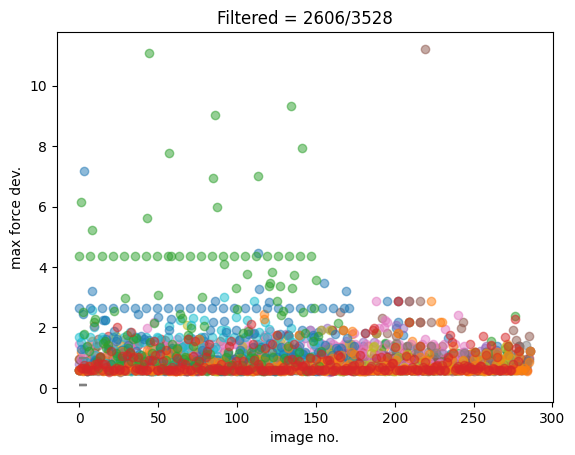

In [13]:
# upper and lower threshold for configuration filtering - these are for max. froce deviation
upthresh = 1
lowthresh = 0.1
filtered_neb = []
total_neb_images = []
good_neb = []
rejected_neb = []
for j, mdev in enumerate(model_dev_i):
    total_neb_images += [len(mdev[:,-3])]
    good_neb += [[i for i,m in enumerate(mdev[:,-3]) if m <= lowthresh]]
    filtered_neb+=[[i for i,m in enumerate(mdev[:,-3]) if m > lowthresh and m <= upthresh]]
    rejected_neb+=[[i for i,m in enumerate(mdev[:,-3]) if m > upthresh]]
    plt.hlines(upthresh, 0,7,'grey',alpha=0.5,linestyles='--')
    plt.hlines(lowthresh, 0,7,'grey',alpha=0.5,linestyles='--')
    plt.plot(mdev[:,-3],'o',alpha=0.5,label=f'rxn_{j}')
plt.title(f'Filtered = {len(sum(filtered_neb,[]))}/{sum(total_neb_images)}')
plt.xlabel('image no.')
plt.ylabel('max force dev.')
config_number = []

In [16]:
print(f'Filtered = {len(sum(filtered_neb,[]))}/{sum(total_neb_images)}')
# config_number
# just a list of lists to find the structures that we have filtered out. 
for rxn in coord_list:
    count = 0
    config_i = []
    for dccomb in rxn:
        config_i += [list(np.arange(count, count+len(dccomb)))]
        count += len(dccomb)
    config_number += [config_i]

Filtered = 2606/3528


In [17]:
# Function that replaces nth line with a replacement_string. Is used for INCAR
# replacing MAGMOM=0 with MAGMOM=NIONS*0
def replace_nth_line(file_path, n, replacement_string):
    # Read the contents of the file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Check if the specified line number is valid
    if 1 <= n <= len(lines):
        # Replace the nth line with the new string
        lines[n] = replacement_string + '\n'
        
        os.system(f'mv {file_path} {file_path}.bk')
        
        # Write the modified content back to the file
        with open(file_path, 'w') as file:
            file.writelines(lines)
        print(f"Successfully replaced line {n} with: {replacement_string}")
    else:
        print(f"Invalid line number: {n}. The file has {len(lines)} lines.")
        
def create_potcar(pos, qm_method, fp_path):
#     poscar = sys.argv[1]
#     qm_method = sys.argv[2] #eg. potpaw_PBE|
    potpath=lambda q,x:f'/ihome/crc/install/intel-2017.1.132/intel-mpi-2017.1.132/vasp/potcars/{q}/{x}/POTCAR'
#     pos=read(poscar)
    sym=pos.get_chemical_symbols()
    sym_un=list(dict.fromkeys(sym))
    if 'POTCAR' in os.listdir(fp_path):
        os.system(f'rm {fp_path}/POTCAR')
    for s in sym_un:
        os.system(f'cat {potpath(qm_method,s)} >> {fp_path}/POTCAR')

In [18]:
ci = config_number[0]
ci
# filtered_neb[0] 
# sampled[0][ri]

[[0, 1, 2, 3, 4, 5, 6],
 [7, 8, 9, 10, 11, 12, 13],
 [14, 15, 16, 17, 18, 19, 20],
 [21, 22, 23, 24, 25, 26, 27],
 [28, 29, 30, 31, 32, 33, 34],
 [35, 36, 37, 38, 39, 40, 41],
 [42, 43, 44, 45, 46, 47, 48],
 [49, 50, 51, 52, 53, 54, 55],
 [56, 57, 58, 59, 60, 61, 62],
 [63, 64, 65, 66, 67, 68, 69],
 [70, 71, 72, 73, 74, 75, 76],
 [77, 78, 79, 80, 81, 82, 83],
 [84, 85, 86, 87, 88, 89, 90],
 [91, 92, 93, 94, 95, 96, 97],
 [98, 99, 100, 101, 102, 103, 104],
 [105, 106, 107, 108, 109, 110, 111],
 [112, 113, 114, 115, 116, 117, 118],
 [119, 120, 121, 122, 123, 124, 125],
 [126, 127, 128, 129, 130, 131, 132],
 [133, 134, 135, 136, 137, 138, 139],
 [140, 141, 142, 143, 144, 145, 146],
 [147, 148, 149, 150, 151, 152, 153],
 [154, 155, 156, 157, 158, 159, 160],
 [161, 162, 163, 164, 165, 166, 167],
 [168, 169, 170, 171, 172, 173, 174],
 [175, 176, 177, 178, 179, 180, 181],
 [182, 183, 184, 185, 186, 187, 188],
 [189, 190, 191, 192, 193, 194, 195],
 [196, 197, 198, 199, 200, 201, 202],
 [203, 2

In [19]:
# preparing jobs for relabeling

# change this piece of code
# try to make it match the /bgfs/kjohnson/ska31/6AA/reactive_active_learning/TiC-methane-coupling/gen-1/neb workflow
for i, rxn in enumerate(filtered_neb):
    ci = config_number[i]
    count = 0

    for f in filtered_neb[i]:
            for ri, row in enumerate(ci):
                if f in row:
                    rj = row.index(f)
                    rxn_dir = f'{relabel_dir}/{str(i).zfill(2)}'
                    if f'{str(i).zfill(2)}' not in os.listdir(relabel_dir):
                        os.mkdir(rxn_dir)
                    job_c = f'{rxn_dir}/{str(count).zfill(4)}'
                    if f'{str(count).zfill(4)}' not in os.listdir(rxn_dir):
                        os.mkdir(job_c)
#                     atom = read(f'{sampled[i][ri]}/opt_converged_000_ase.xyz', index=rj)
                    atom = read(f'{sampled[i][ri]}',index=rj)
                    write(f'{job_c}/POSCAR', atom, sort=True)
                    os.system(f'cp {input_path}/INCAR.sp {job_c}/INCAR')
                    os.system(f'cp {input_path}/job.slurm {job_c}/job.slurm')
                    atoms = read(f'{job_c}/POSCAR')
                    create_potcar(atoms, 'potpaw_PBE', job_c)
                    count += 1
                    
                    break